In [1]:
import pandas as pd

In [ ]:
complexity = pd.read_csv('data/TextComplexityDE_aligned_pred.csv')
complexity = complexity[complexity.Rating != "Nicht einfacher / konnte nicht vereinfacht werden"]
deplain = pd.read_csv("data/deplain_simplified_pred.csv")

In [ ]:
complexity

In [ ]:
from datasets import load_dataset

deplain_ds = load_dataset("DEplain/DEplain-web-sent")

level_to_id = {'a1': 1, 'a2': 2, 'b1': 3, 'b2': 4, 'c1': 5, 'c2': 6}
levels = {o: level_to_id[l] for o, l in zip(deplain_ds['test']['original'], deplain_ds['test']['language_level_original'])}
deplain['level_orig'] = deplain['normal_phrase'].apply(lambda x: levels.get(x))
levels = {s: level_to_id[l] for s, l in zip(deplain_ds['test']['simplification'], deplain_ds['test']['language_level_simple'])}
deplain['level_simple'] = deplain['simple_phrase'].apply(lambda x: levels.get(x))
simp_strength = []
for _, row in deplain.iterrows():
    simp_strength.append(row.level_orig - row.level_simple)
deplain['simp_strength'] = simp_strength
deplain

In [7]:
deplain.groupby(['level_simple', 'level_orig']).size().reset_index().rename(columns={0:'count'})

,level_simple,level_orig,count
0,1,6,650
1,2,4,158
2,2,6,1038


In [8]:
deplain['level_simple'].unique()

array([2, 1], dtype=int64)

In [9]:
deplain['simp_strength'][deplain['simp_strength'] >= 5] = 4 # group samples with strong simplification
deplain['simp_strength'].unique()

C:\Users\Miriam\AppData\Local\Temp\ipykernel_5804\3925421906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deplain['simp_strength'][deplain['simp_strength'] >= 5] = 4 # group samples with strong simplification


array([2, 4], dtype=int64)

In [10]:
def compare_task(task, df, simplified_column='_simple'):
    same_pred = []
    for n, s in zip(df[task + '_normal'], df[task + simplified_column]):
        if type(n)==str and type(s) == str:
            same_pred.append(n.lower()==s.lower())
        else:
            same_pred.append(n==s)
    different = same_pred.count(False)
    error = round(100*different/len(same_pred), 2)
    print(f"**{task} error rate: {error}% with {len(same_pred)} samples")
    return error

tasks = [
    #'sentiment',
    'toxicity',
    'topic_gnad',
    'sentiment_news'
]

errors_per_level = {}
#for simp, group in aligned_combined.groupby('V_simple'):
#for simp, group in complexity.groupby('Rating'):
for simp, group in deplain.groupby('simp_strength'):
#for simp in ['Vp', 'V1', 'V2', 'V3', 'V4', 'Vs']:
    #group = aligned_combined[aligned_combined.V_simple == simp]
    print('\n*', simp)
    df_tmp = {}
    for task in tasks:
        df_tmp[task] = compare_task(task, group)
    errors_per_level[simp] = df_tmp

def calculate_errors(df, column_name):
    print(column_name)
    errors_per_level = {}
    for simp, group in df.groupby(column_name):
        print('\n*', simp)
        df_tmp = {}
        for task in tasks:
            df_tmp[task] = compare_task(task, group)
        errors_per_level[simp] = df_tmp
    return errors_per_level

errors_per_level_deplain_strength = calculate_errors(deplain, 'simp_strength')#'level_simple')
errors_per_level_deplain_level = calculate_errors(deplain, 'level_orig')
errors_per_level_complex = calculate_errors(complexity, 'Rating')


* 2
**toxicity error rate: 0.0% with 158 samples
**topic_gnad error rate: 13.92% with 158 samples
**sentiment_news error rate: 12.03% with 158 samples

* 4
**toxicity error rate: 4.38% with 1688 samples
**topic_gnad error rate: 33.83% with 1688 samples
**sentiment_news error rate: 24.17% with 1688 samples
simp_strength

* 2
**toxicity error rate: 0.0% with 158 samples
**topic_gnad error rate: 13.92% with 158 samples
**sentiment_news error rate: 12.03% with 158 samples

* 4
**toxicity error rate: 4.38% with 1688 samples
**topic_gnad error rate: 33.83% with 1688 samples
**sentiment_news error rate: 24.17% with 1688 samples
level_orig

* 4
**toxicity error rate: 0.0% with 158 samples
**topic_gnad error rate: 13.92% with 158 samples
**sentiment_news error rate: 12.03% with 158 samples

* 6
**toxicity error rate: 4.38% with 1688 samples
**topic_gnad error rate: 33.83% with 1688 samples
**sentiment_news error rate: 24.17% with 1688 samples
Rating

* Deutlich einfacher
**toxicity error rate:

In [11]:
errors_per_level_complex

{'Deutlich einfacher': {'toxicity': 0.0,
  'topic_gnad': 20.18,
  'sentiment_news': 7.02},
 'Etwas einfacher': {'toxicity': 0.0,
  'topic_gnad': 17.78,
  'sentiment_news': 2.96}}

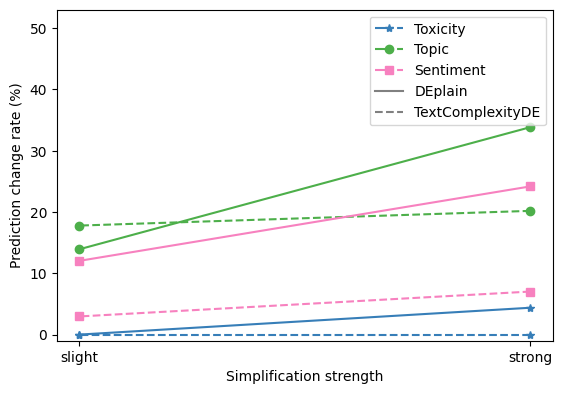

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(6.4, 4.3))

colors = {
    #'sentiment': 'lightblue',
    'sentiment_news': '#f781bf',
    'toxicity': '#377eb8',
    'topic_gnad': '#4daf4a',
}
labels = {
    'sentiment_news': 'Sentiment',
    'toxicity': 'Toxicity',
    'topic_gnad': 'Topic',
}
markers = {
    'toxicity': '*',
    'topic_gnad': 'o',
    'sentiment_news': 's',
}

for task in tasks:
    #plt.plot([errors_per_level_deplain[level][task] for level in [2, 1]], label=task, color=colors[task], linestyle='dashed')
    plt.plot([1, 0], [level[task] for level in errors_per_level_complex.values()], color=colors[task], linestyle='dashed', marker=markers[task]) #switch order to match DEplain levels
    plt.plot([level[task] for level in errors_per_level_deplain_strength.values()], color=colors[task], linestyle='solid', marker=markers[task])
    #plt.scatter(2, compare_task(task, brandeins), marker='^', color=colors[task])
    #plt.scatter(1, compare_task(task, wahlprogramm), marker='*', color=colors[task])
    #plt.scatter(1, compare_task(task, deplain), marker='>', color=colors[task])
    #plt.scatter(1, compare_task(task, deplain, '_simplified'), marker='<', color=colors[task])


#plt.scatter(2, compare_task('topic_gpt3', brandeins), marker='^', color='red')
for task in tasks:
    plt.plot([], color=colors[task], linestyle='dashdot', label=labels[task], marker=markers[task])
plt.plot([], color='grey', label='DEplain', linestyle='solid')
plt.plot([], color='grey', label='TextComplexityDE', linestyle='dashed')
#plt.scatter([], [], marker='^', color='grey', label='brandeins')
#plt.scatter([], [], marker='*', color='grey', label='wahlprogramm')
#plt.scatter([], [], marker='>', color='grey', label='deplain')
#plt.scatter([], [], marker='<', color='grey', label='deplain auto')

plt.xticks([0,1],['slight', 'strong'])
legend = plt.legend()
#handles, labels = legend.axes.get_legend_handles_labels()
#handles.append(mpatches.Patch(color='grey', label='brandeins', marker='*'))
#labels.append('brandeins')
#plt.legend(handles=handles, labels=labels)

plt.ylabel('Prediction change rate (%)')
plt.xlabel('Simplification strength')
plt.ylim(-1, 53)
plt.savefig('plots_new/german.pdf')
plt.show()

In [13]:
errors_per_level_deplain_level

{4: {'toxicity': 0.0, 'topic_gnad': 13.92, 'sentiment_news': 12.03},
 6: {'toxicity': 4.38, 'topic_gnad': 33.83, 'sentiment_news': 24.17}}

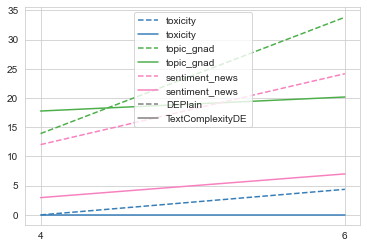

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = {
    #'sentiment': 'lightblue',
    'sentiment_news': '#f781bf',
    'toxicity': '#377eb8',
    'topic_gnad': '#4daf4a',
}

for task in tasks:
    plt.plot([errors_per_level_deplain_level[level][task] for level in [4, 6]], label=task, color=colors[task], linestyle='dashed')
    plt.plot([1, 0], [level[task] for level in errors_per_level_complex.values()], label=task, color=colors[task], linestyle='solid')

plt.plot([], color='grey', label='DEPlain', linestyle='dashed')
plt.plot([], color='grey', label='TextComplexityDE', linestyle='solid')

plt.xticks(range(len(errors_per_level_deplain_level.keys())), labels=errors_per_level_deplain_level.keys())
legend = plt.legend()
plt.show()

In [ ]:
# For topic classification: https://huggingface.co/Mathking/bert-base-german-cased-gnad10

In [12]:
from tqdm import tqdm
from Levenshtein import distance, ratio
import matplotlib.pyplot as plt

distances = []
num_errors = []
aligned_combined = pd.concat([deplain, complexity])

for _, row in tqdm(aligned_combined.iterrows(), total=len(aligned_combined)):
    errors = 0
    for task in colors.keys():
        if row[task + '_normal'] != row[task + '_simple']:
            errors += 1
    num_errors.append(errors)
    distances.append(distance(row.normal_phrase, row.simple_phrase)/len(row.normal_phrase))#, score_cutoff=100))
    #distances.append(ratio(row.normal_phrase, row.simple_phrase))

100%|██████████| 2095/2095 [00:00<00:00, 9392.93it/s]


Text(0, 0.5, 'Levenshtein distance')

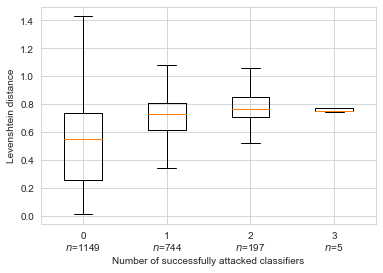

In [13]:
import numpy as np
dists = {
    0: np.array(distances)[np.array(num_errors) == 0].tolist(),
    1: np.array(distances)[np.array(num_errors) == 1].tolist(),
    2: np.array(distances)[np.array(num_errors) == 2].tolist(),
    3: np.array(distances)[np.array(num_errors) == 3].tolist(),
}

fig, ax = plt.subplots()
ax.boxplot(dists.values(), showfliers=False)
ax.set_xticklabels([f"{k}\n$n$={len(dists[k])}" for k in dists.keys()])
plt.xlabel("Number of successfully attacked classifiers")
plt.ylabel("Levenshtein distance")

In [14]:
import json
with open('lev_dist_german.json', 'w') as fp:
    json.dump(dists, fp)

## Label distribution

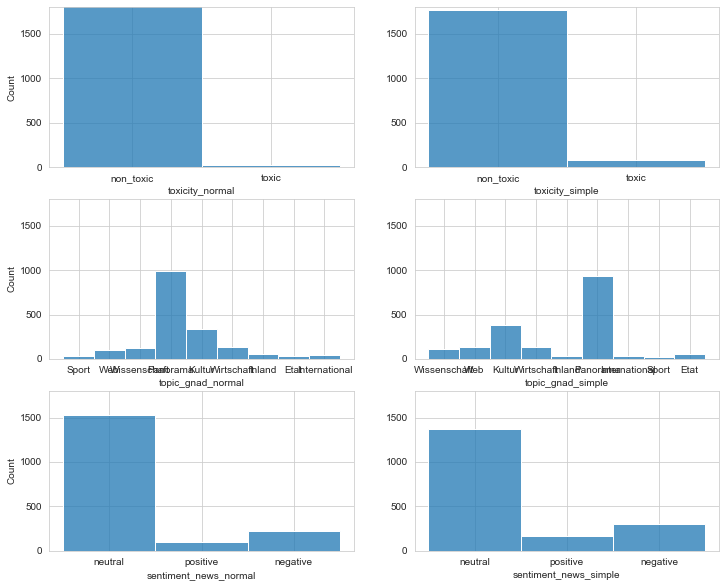

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(12, 10))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        col.set_ylim([0, 1800])
        sns.histplot(data=deplain[task + identifier],discrete=True, ax=col)  # RUN PLOT
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()

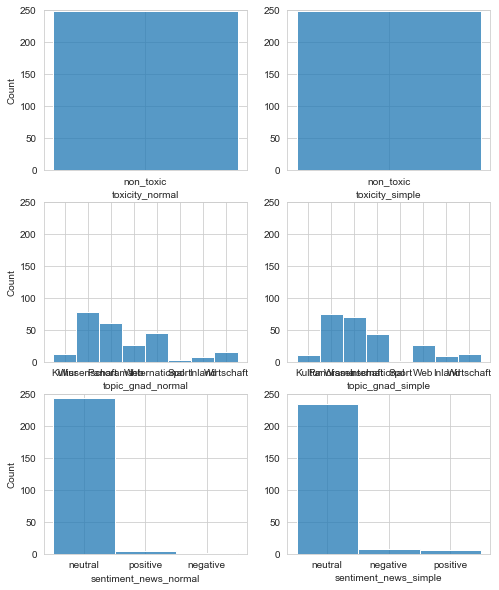

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(8, 10))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        col.set_ylim([0, 250])
        sns.histplot(data=complexity[task + identifier],discrete=True, ax=col)  # RUN PLOT
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()